<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [32]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re
from spacy.tokenizer import Tokenizer

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [4]:
df = pd.read_csv('./data/job_listings.csv')

In [5]:
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [20]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
# clean the description
df['clean_description'] = df['description'].apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())
# clean up the \n charaters
df['clean_description'] = df['clean_description'].apply(lambda text: text.replace("\\n", " "))
# clean up the front text that shows the body
df['clean_description'] = df['clean_description'].apply(lambda text: text.replace("b\"", ""))
df['clean_description'] = df['clean_description'].apply(lambda text: text.replace("b\'", ""))

In [30]:
df.head()

,Unnamed: 0,description,title,clean_description
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...


## 2) Use Spacy to tokenize the listings 

In [33]:
# Inialize spaCy model and tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [51]:
tokens = []

# Return lower case tokens and ignore stop words/punctuation
for doc in tokenizer.pipe(df['clean_description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        # ignore stopwords, spaces and punctuation
        if (token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['spaCy_tokens'] = tokens
df['spaCy_tokens'].head()

0    [job, requirements:, conceptual, understanding...
1    [job, description, data, scientist, 1,, help, ...
2    [data, scientist, working, consulting, busines...
3    [$4,969, $6,756, monthcontractunder, general, ...
4    [location:, usa, \xe2\x80\x93, multiple, locat...
Name: spaCy_tokens, dtype: object

In [57]:
df.head()

,Unnamed: 0,description,title,clean_description,spaCy_tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,Job Requirements: Conceptual understanding in ...,"[job, requirements:, conceptual, understanding..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"Job Description As a Data Scientist 1, you wi...","[job, description, data, scientist, 1,, help, ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,As a Data Scientist you will be working on con...,"[data, scientist, working, consulting, busines..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthContractUnder the gener...","[$4,969, $6,756, monthcontractunder, general, ..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,Location: USA \xe2\x80\x93 multiple locations ...,"[location:, usa, \xe2\x80\x93, multiple, locat..."


In [61]:
df.shape

(426, 5)

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [106]:
from sklearn.feature_extraction.text import CountVectorizer

# create the transformer
vect = CountVectorizer()

# build vocab
data = df['clean_description']
vect.fit(data)

# transform text
dtm = vect.transform(data)
print(dtm.shape)

(426, 8758)


In [89]:
import seaborn as sns
sns.set()

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    
    # Arguments
        samples_texts: list, sample texts.
    """
    num_words = [len(s.split()) for s in sample_texts]
    
    plt.figure(figsize=(8,6))
    sns.distplot(num_words)
    plt.title('Number of Words per Document', fontsize=14)
    plt.xlabel('Number of Words', fontsize=12)
    plt.ylabel('Proportion of documents', fontsize=12)
    plt.show()

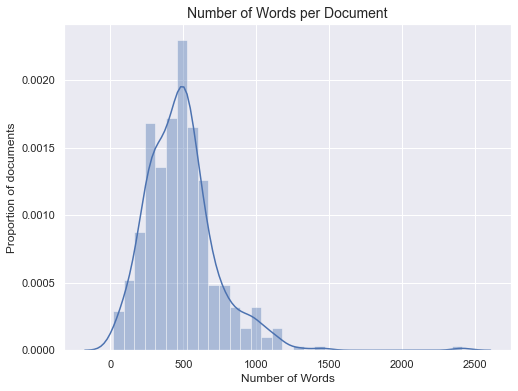

In [105]:
plot_sample_length_distribution(data)

## 4) Visualize the most common word counts

In [81]:
from collections import Counter

def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts of words in the document set.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [82]:
wc = count(df['spaCy_tokens'])
print(wc.shape)
wc.head()

(15389, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
76,data,421,3914,1.0,0.029438,0.029438,0.988263
2,experience,401,1668,2.0,0.012546,0.041984,0.941315
53,work,350,1063,3.0,0.007995,0.049979,0.821596
221,business,303,1052,4.0,0.007912,0.057891,0.711268
91,team,325,786,5.0,0.005912,0.063803,0.762911


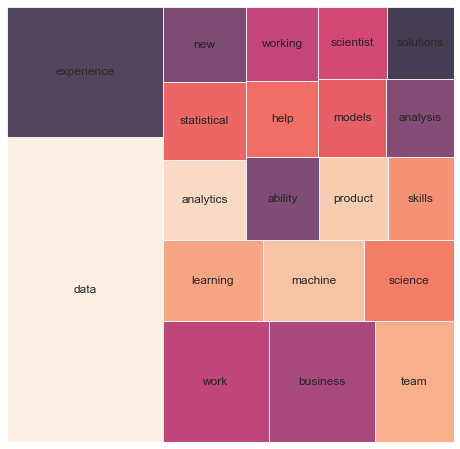

In [84]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(8,8))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english',
                        # tokenizer = tokenize,
                        ngram_range = (1,2),
                        min_df = 6, 
                        max_df = 0.5)

# Create a vocabulary and tf-idf score per document
dtm = tfidf.fit_transform(data)

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(426, 4789)


,000,10,10 years,100,100 000,100 countries,11,12,12 months,15,...,years industry,years professional,years related,years relevant,years work,years working,years xe2,yes,york,york city
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [116]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [117]:
# get the top 5 nearest neighbors
nn.kneighbors([dtm.iloc[0].values])

(array([[0.        , 1.29616063, 1.31170469, 1.32350446, 1.32854316]]),
 array([[  0, 338, 115, 393, 168]], dtype=int64))

In [119]:
# print the job title and the first part of the description, for the top two
a = 0
b = 338
print(df['title'][a])
print(data[a][:150])
print(df['title'][b])
print(data[b][:150])

Data scientist 
Job Requirements: Conceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Ne
Manufacturing Data Scientist
The FCA Manufacturing Planning and Control (MPC) organization is currently seeking a highly skilled, result-oriented Data Scientist to join our BDA (B


In [131]:
# Write out the ideal job description

ideal = ["Looking for someone to build Machine learning models of google maps. Analize the data of these maps to predict residential and farm growth."]

print(ideal)

['Looking for someone to build Machine learning models of google maps. Analize the data of these maps to predict residential and farm growth.']


In [132]:
# compare with the nearest neighbors model

new = tfidf.transform(ideal)
new

<1x4789 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [133]:
nn.kneighbors(new.todense())

(array([[1.23080747, 1.23080747, 1.23080747, 1.26148918, 1.31388263]]),
 array([[275, 240, 334,  65, 335]], dtype=int64))

In [135]:
# Print the top two results

a = 275
b = 240
print(df['title'][a])
print(data[a][:150])
print(df['title'][b])
print(data[b][:150])

Data Scientist, Operations Data Science
Minimum qualifications: Master's degree in Operations Research, Industrial Engineering, Statistics, related field, or equivalent practical experience.
Data Scientist, Operations Data Science
Minimum qualifications: Master's degree in Operations Research, Industrial Engineering, Statistics, related field, or equivalent practical experience.


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 